# Importing libraries

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from torch.utils.data import DataLoader, TensorDataset

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# Data loading 

In [9]:
df=pd.read_csv("cleaned.csv")
# scaler=StandardScaler()
X=df.drop(columns=["Diabetes_012"]).values
# X=scaler.fit_transform(X)  
y=df["Diabetes_012"].values
num_classes=len(np.unique(y))
y_one_hot=np.eye(num_classes)[y]
X_train,X_test,y_train,y_test=train_test_split(X,y_one_hot,test_size=0.2,random_state=42,stratify=y)

In [16]:
X_train_tensor=torch.tensor(X_train,dtype=torch.float32).to(device)
X_test_tensor=torch.tensor(X_test,dtype=torch.float32).to(device)
y_train_tensor=torch.tensor(y_train,dtype=torch.float32).to(device)
y_test_tensor=torch.tensor(y_test,dtype=torch.float32).to(device)

batch_size=64
train_dataset=TensorDataset(X_train_tensor,y_train_tensor)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

test_dataset=TensorDataset(X_test_tensor,y_test_tensor)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Neural network class

In [17]:
class DiabetesNN(nn.Module):
    def __init__(self, input_size):
        super(DiabetesNN, self).__init__()
        self.fc1=nn.Linear(input_size,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,32)
        self.fc4=nn.Linear(32,num_classes)
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout(0.3)
    
    def forward(self,x):
        x=self.relu(self.fc1(x))
        x=self.dropout(x)
        x=self.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.relu(self.fc3(x))
        x=self.fc4(x)
        return x

# Training phase

In [18]:
input_size=X_train.shape[1]
model=DiabetesNN(input_size).to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=0.001,weight_decay=1e-4)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=5,verbose=True)
scaler=torch.amp.GradScaler('cuda')

num_epochs=150
train_losses=[]
val_losses=[]

for epoch in range(num_epochs):
    model.train()
    total_loss=0
    for batch_X,batch_y in train_loader:
        batch_X,batch_y=batch_X.to(device),batch_y.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs=model(batch_X)
            loss=criterion(outputs,batch_y.argmax(dim=1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss+=loss.item()
    
    train_losses.append(total_loss/len(train_loader))
    
    model.eval()
    val_loss=0
    with torch.no_grad():
        for batch_X,batch_y in test_loader:
            batch_X,batch_y=batch_X.to(device),batch_y.to(device)
            outputs=model(batch_X)
            loss=criterion(outputs,batch_y.argmax(dim=1))
            val_loss+=loss.item()
    val_losses.append(val_loss/len(test_loader))
    
    scheduler.step(val_losses[-1])
    
    if (epoch+1)%10==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

with torch.no_grad():
    y_pred_probs=model(X_test_tensor)
    y_pred=torch.argmax(y_pred_probs,dim=1).cpu().numpy()

y_test_labels=np.argmax(y_test,axis=1)

c:\Users\charu\anaconda3\envs\myenv2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/150], Train Loss: 0.5038, Val Loss: 0.4867, LR: 0.001000
Epoch [20/150], Train Loss: 0.4984, Val Loss: 0.4895, LR: 0.001000
Epoch [30/150], Train Loss: 0.4920, Val Loss: 0.4845, LR: 0.000500
Epoch [40/150], Train Loss: 0.4879, Val Loss: 0.4839, LR: 0.000250
Epoch [50/150], Train Loss: 0.4846, Val Loss: 0.4843, LR: 0.000125
Epoch [60/150], Train Loss: 0.4834, Val Loss: 0.4841, LR: 0.000063
Epoch [70/150], Train Loss: 0.4822, Val Loss: 0.4838, LR: 0.000016
Epoch [80/150], Train Loss: 0.4831, Val Loss: 0.4838, LR: 0.000004
Epoch [90/150], Train Loss: 0.4822, Val Loss: 0.4837, LR: 0.000002
Epoch [100/150], Train Loss: 0.4821, Val Loss: 0.4837, LR: 0.000000
Epoch [110/150], Train Loss: 0.4818, Val Loss: 0.4837, LR: 0.000000
Epoch [120/150], Train Loss: 0.4817, Val Loss: 0.4837, LR: 0.000000
Epoch [130/150], Train Loss: 0.4823, Val Loss: 0.4837, LR: 0.000000
Epoch [140/150], Train Loss: 0.4816, Val Loss: 0.4837, LR: 0.000000
Epoch [150/150], Train Loss: 0.4825, Val Loss: 0.4837, LR

# Outputs and plots

Accuracy: 78.69408945686901 %

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      8000
           1       1.00      0.88      0.93      3512
           2       0.60      0.50      0.55      3512

    accuracy                           0.79     15024
   macro avg       0.79      0.75      0.77     15024
weighted avg       0.79      0.79      0.78     15024



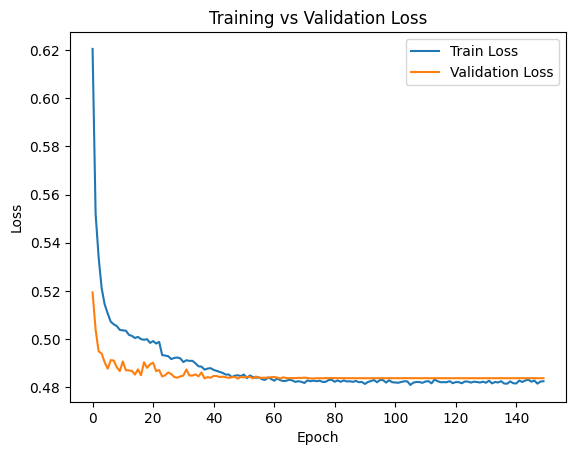

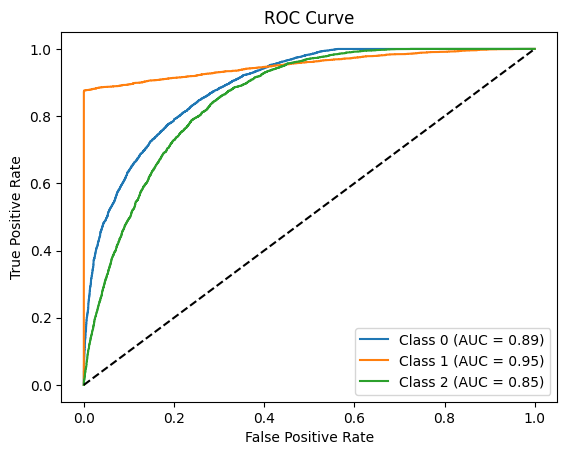

In [29]:
acc=accuracy_score(y_test_labels, y_pred)
print("Accuracy:",acc*100,"%")
print()
print("Classification Report:\n", classification_report(y_test_labels,y_pred))

plt.plot(train_losses,label='Train Loss')
plt.plot(val_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

fpr={}
tpr={}
roc_auc={}

for i in range(num_classes):
    fpr[i],tpr[i],_=roc_curve(y_test[:,i],y_pred_probs[:,i].cpu().numpy())
    roc_auc[i]=auc(fpr[i],tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i],tpr[i],label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


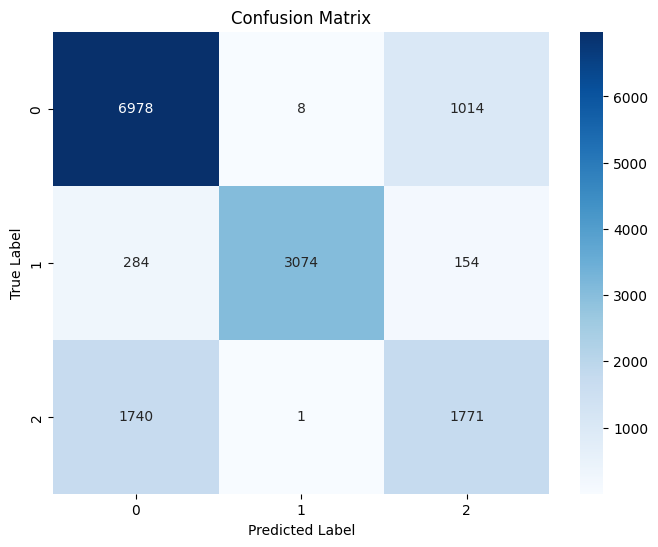

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()